In [9]:

# Import libraries for SVM
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

# Load the data
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Subsample for faster execution 
df = df.sample(frac=0.1, random_state=42)

# Handling the Date Column (datestring - datatime)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df.drop('Date', axis=1, inplace=True)

X = df.drop('RainTomorrow', axis=1)
y = LabelEncoder().fit_transform(df['RainTomorrow'])

categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
binary_cat = ['RainToday']
numerical_cols = [col for col in X.columns if col not in categorical_cols + binary_cat]

#apply different preprocessing methods 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('bin', OneHotEncoder(drop='first', sparse_output=False), binary_cat)
    ])

# Transformations 
X_processed = preprocessor.fit_transform(X)
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out()) + list(preprocessor.named_transformers_['bin'].get_feature_names_out())
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

Saving Weather Data Set.csv to Weather Data Set (2).csv


In [12]:
# Member 3: SVM code (Creating and Tuning)
svm = SVC(probability=True, class_weight='balanced', random_state=42)
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear'], 'gamma': ['scale']}
grid_svm = RandomizedSearchCV(svm, param_grid_svm, n_iter=3, cv=StratifiedKFold(n_splits=3), scoring='f1', random_state=42)
grid_svm.fit(X_train, y_train)

print(f'Best Params: {grid_svm.best_params_}')
best_svm = grid_svm.best_estimator_

Best Params: {'kernel': 'linear', 'gamma': 'scale', 'C': 1}


CV Accuracy: 0.8016 ± 0.0052
Accuracy: 0.7928
F1: 0.6067
Precision: 0.5225
Recall: 0.7232
AUC: 0.8604


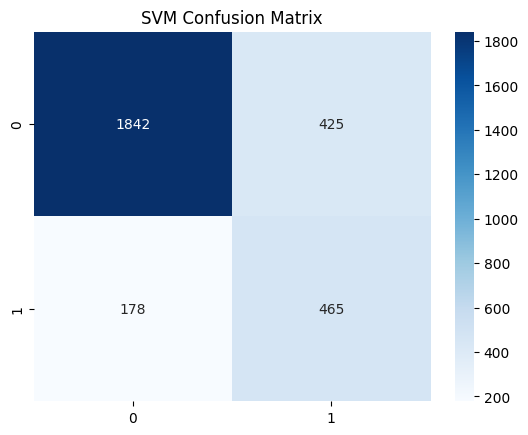

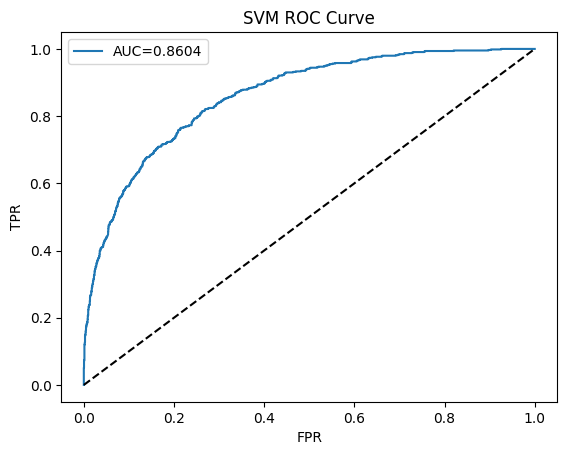

In [13]:
cv_scores = cross_val_score(best_svm, X_train, y_train, cv=3, scoring='accuracy')
print(f'CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

y_pred_svm = best_svm.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}')
print(f'F1: {f1_score(y_test, y_pred_svm):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_svm):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_svm):.4f}')
print(f'AUC: {roc_auc_score(y_test, best_svm.predict_proba(X_test)[:,1]):.4f}')

cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, best_svm.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, best_svm.predict_proba(X_test)[:,1]):.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('SVM ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()
plt.show()